In [1]:
%load_ext autoreload
%autoreload 2

import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import timeit
import pickle

from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report, f1_score, mean_squared_log_error, recall_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn import svm, tree    #https://scikit-learn.org/stable/modules/svm.html
                                 #https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#-------------ACTIVE LEARNING LIBRARY
from modAL.models import ActiveLearner             #https://modal-python.readthedocs.io/en/latest/content/models/ActiveLearner.html
from modAL.uncertainty import entropy_sampling     #https://modal-python.readthedocs.io/en/latest/content/apireference/uncertainty.html
from modAL.disagreement import vote_entropy_sampling

#------------IMBALANCED DATA SETS LIBRARY
from imblearn.over_sampling import SMOTEN
from imblearn.under_sampling import EditedNearestNeighbours, ClusterCentroids, RandomUnderSampler 

from collections import Counter

import sys
sys.path.insert(0, '/home/jovyan/Thesis_ActLearn_DOP_2022/main/active_learning/')
import functions as fun
import reg_icp as ricp
import emcm 

In [2]:
# Loading data sets
cell_profiler = pd.read_csv('/home/jovyan/Thesis_ActLearn_DOP_2022/main/supervised_learning/regression_data_batchA.csv')
print(f'There are {len(cell_profiler)} rows in the Batch A')

There are 5167 rows in the Batch A


In [3]:
# Selecting features according to the paper
group1 = [col for col in cell_profiler.columns if ('Granu' in col  and 'SYTO' in col) or ('Inten' in col and 'SYTO' in col) and not 'Location' in col and not 'Radial' in col]
group2 = [col for col in cell_profiler.columns if ('Granu' in col  and 'CONC' in col) or ('Inten' in col and 'CONC' in col) and not 'Location' in col and not 'Radial' in col]
group3 = [col for col in cell_profiler.columns if 'Correla' in col or 'Neig' in col]

filtered_features = group1+group2+group3

# Filtering
filtered_cell_profiler = cell_profiler[filtered_features+['Target']]

In [4]:
# Output values
X_filtered = filtered_cell_profiler.drop(['Target'], axis = 1).to_numpy()
y = 1000*filtered_cell_profiler.iloc[:,-1].to_numpy()

In [5]:
# Parameters for ML model
train_size = 0.1
test_size = 0.3

# split dataset into train(- %), test(- %), unlabel(- %)
x_train, y_train, x_test, y_test, x_pool, y_pool = fun.split(x_dataset = X_filtered, y_dataset = y, 
                                                             ini_train_size = train_size, test_size = test_size)

In [6]:
print(f'The inicial training set has size {len(x_train)}')
print(f'The inicial pool set has size {len(x_pool)}')
print(f'The inicial test set has size {len(x_test)}')

The inicial training set has size 361
The inicial pool set has size 3255
The inicial test set has size 1551


In [7]:
# Creating the best models for analysis
linear_model = Ridge(alpha=1.3, random_state=0)

In [8]:
#Target from supervised machine learning
target = 0.3215
linear_model_v2 = Ridge(alpha=1.3, random_state=0)

# Parameters for AL
k_members = 3

#Define query strategy 
query_str = emcm.emcm_query
    
performance_history_v2 = []

#Fit model to initial data
linear_model_v2.fit(x_train, y_train)

#Making predictions
y_pred = linear_model_v2.predict(x_test)

#Calculate and report our model's accuracy.
model_accuracy = mean_squared_error(y_pred , y_test)

# Save our model's performance for plotting.
performance_history_v2.append(model_accuracy)
collections = 0

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy emcm.
while len(x_pool) > 0:
    
    if collections == 0:
        print('Inside AL')
    
    #Query for a new point
    query_index, query_instance = query_str(x_train, y_train, x_pool, linear_model_v2, k_members)
    collections += 1
    
    # Teach our ActiveLearner model the record it has requested.
    XX, yy = x_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
    x_train = np.append(x_train, XX, axis = 0)
    y_train = np.append(y_train, yy, axis = 0)

    # Remove the queried instance from the unlabeled pool.
    x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)
    
    # Re- training in new data
    linear_model_v2.fit(x_train, y_train)
    
    #Predict given the new point
    y_pred = linear_model_v2.predict(x_test)
    
    #Store performance
    model_accuracy = mean_squared_error(y_pred , y_test)
    performance_history_v2.append(model_accuracy)

    if collections % 100 == 0:
        print('Accuracy after query {n}: {acc:0.4f}'.format(n = collections, acc = model_accuracy))
    
    if abs(target - model_accuracy) < 0.005:
        print(f'Target reached! \n Number of queries performed {collections}')
        break

Inside AL
Accuracy after query 100: 0.4299
Accuracy after query 200: 0.4049
Accuracy after query 300: 0.3964
Accuracy after query 400: 0.3890
Accuracy after query 500: 0.3818
Accuracy after query 600: 0.3806
Accuracy after query 700: 0.3740
Accuracy after query 800: 0.3672
Accuracy after query 900: 0.3667
Accuracy after query 1000: 0.3649
Accuracy after query 1100: 0.3639
Accuracy after query 1200: 0.3643
Accuracy after query 1300: 0.3643
Accuracy after query 1400: 0.3635
Accuracy after query 1500: 0.3631
Accuracy after query 1600: 0.3625
Accuracy after query 1700: 0.3614
Accuracy after query 1800: 0.3614
Accuracy after query 1900: 0.3614
Accuracy after query 2000: 0.3604
Accuracy after query 2100: 0.3591
Accuracy after query 2200: 0.3585
Accuracy after query 2300: 0.3578
Accuracy after query 2400: 0.3579
Accuracy after query 2500: 0.3560
Accuracy after query 2600: 0.3546
Accuracy after query 2700: 0.3541
Accuracy after query 2800: 0.3536
Accuracy after query 2900: 0.3536
Accuracy afte

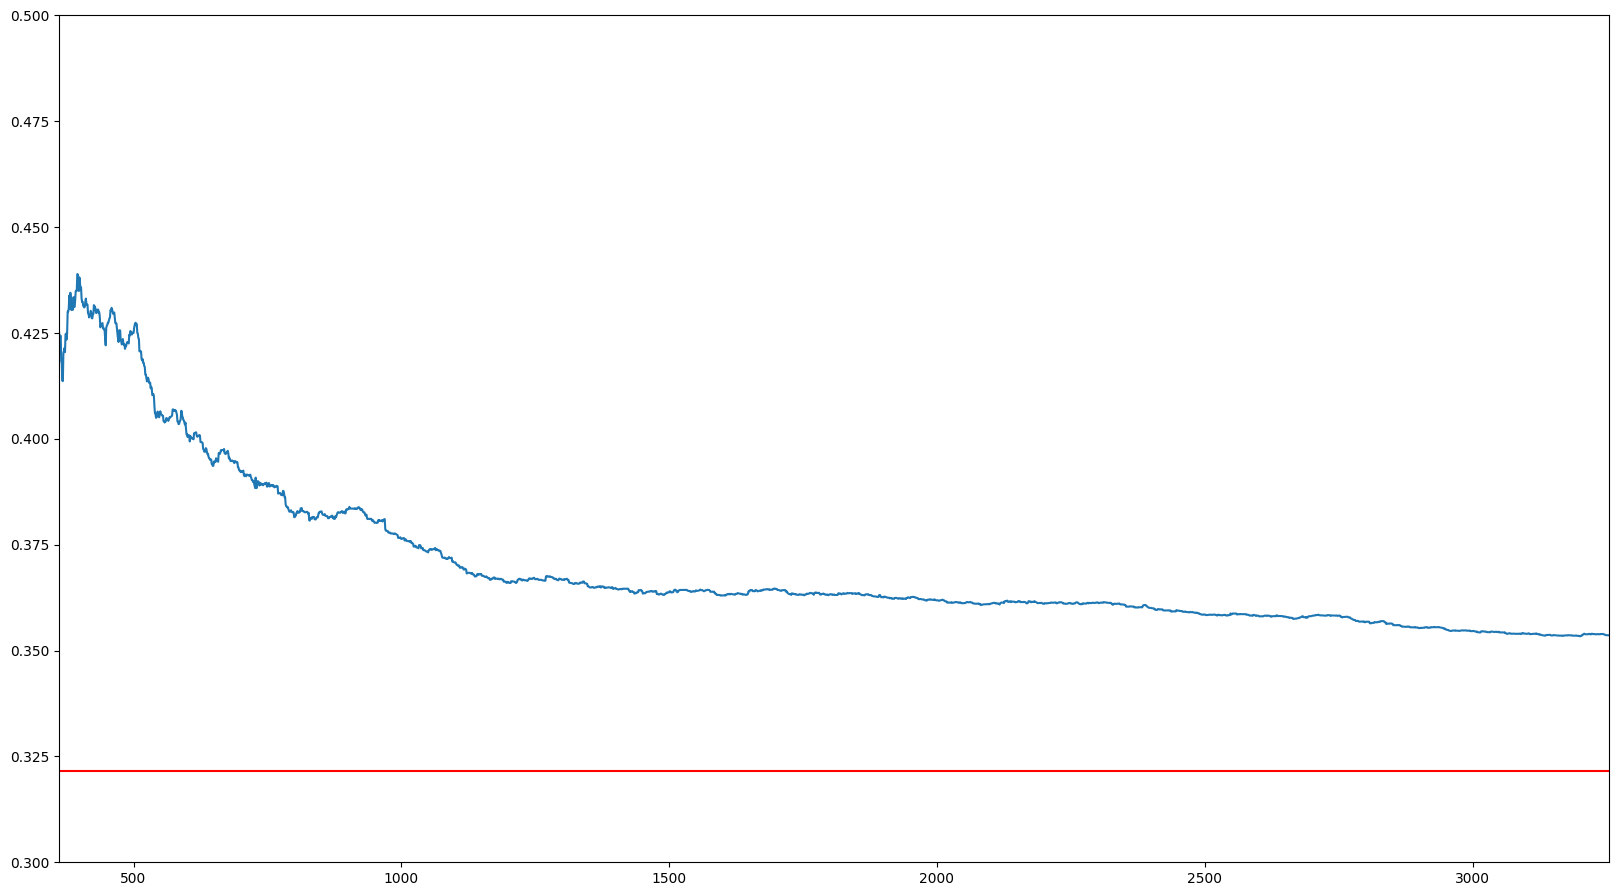

In [15]:
xxx = np.arange(361, len(x_train) + 1, 1)
fig, ax = plt.subplots(1, 1, figsize=(20,11))
ax.plot(xxx, performance_history_v2)#, marker = 'o', s=7, color=[.937, .275, .282], linewidth=0.8)
ax.set_ylim([0.3, 0.5])
ax.set_xlim([361, 3255])
plt.axhline(y = 0.3215, color='r', linestyle='-')
plt.show()

In [16]:
# Parameters for ML model
train_size = 0.2
test_size = 0.2

# split dataset into train(- %), test(- %), unlabel(- %)
x_train, y_train, x_test, y_test, x_pool, y_pool = fun.split(x_dataset = X_filtered, y_dataset = y, 
                                                             ini_train_size = train_size, test_size = test_size)

In [17]:
print(f'The inicial training set has size {len(x_train)}')
print(f'The inicial pool set has size {len(x_pool)}')
print(f'The inicial test set has size {len(x_test)}')

The inicial training set has size 826
The inicial pool set has size 3307
The inicial test set has size 1034


In [18]:
#Target from supervised machine learning
target = 0.3215
linear_model_v3 = Ridge(alpha=1.3, random_state=0)

# Parameters for AL
k_members = 3

#Define query strategy 
query_str = emcm.emcm_query
    
performance_history_v3 = []

#Fit model to initial data
linear_model_v3.fit(x_train, y_train)

#Making predictions
y_pred = linear_model_v3.predict(x_test)

#Calculate and report our model's accuracy.
model_accuracy = mean_squared_error(y_pred , y_test)

# Save our model's performance for plotting.
performance_history_v3.append(model_accuracy)
collections = 0

# Allow our model to query our unlabeled dataset for the most
# informative points according to our query strategy emcm.
while len(x_pool) > 0:
    
    if collections == 0:
        print('Inside AL')
    
    #Query for a new point
    query_index, query_instance = query_str(x_train, y_train, x_pool, linear_model_v3, k_members)
    collections += 1
    
    # Teach our ActiveLearner model the record it has requested.
    XX, yy = x_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
    x_train = np.append(x_train, XX, axis = 0)
    y_train = np.append(y_train, yy, axis = 0)

    # Remove the queried instance from the unlabeled pool.
    x_pool, y_pool = np.delete(x_pool, query_index, axis=0), np.delete(y_pool, query_index)
    
    # Re- training in new data
    linear_model_v3.fit(x_train, y_train)
    
    #Predict given the new point
    y_pred = linear_model_v3.predict(x_test)
    
    #Store performance
    model_accuracy = mean_squared_error(y_pred , y_test)
    performance_history_v3.append(model_accuracy)

    if collections % 100 == 0:
        print('Accuracy after query {n}: {acc:0.4f}'.format(n = collections, acc = model_accuracy))
    
    if abs(target - model_accuracy) < 0.005:
        print(f'Target reached! \n Number of queries performed {collections}')
        break

Inside AL
Accuracy after query 100: 0.3639
Accuracy after query 200: 0.3560
Accuracy after query 300: 0.3525
Accuracy after query 400: 0.3427
Accuracy after query 500: 0.3408
Accuracy after query 600: 0.3413
Accuracy after query 700: 0.3388
Accuracy after query 800: 0.3363
Accuracy after query 900: 0.3376
Accuracy after query 1000: 0.3368
Accuracy after query 1100: 0.3347
Accuracy after query 1200: 0.3343
Accuracy after query 1300: 0.3318
Accuracy after query 1400: 0.3306
Accuracy after query 1500: 0.3306
Accuracy after query 1600: 0.3291
Accuracy after query 1700: 0.3283
Accuracy after query 1800: 0.3268
Target reached! 
 Number of queries performed 1804


In [19]:
print('Done')

Done


In [22]:
len(x_pool)

1503